In [1]:
#Mapa planta perfil

In [2]:
import numpy as np
import csv
import pandas as pd 
import matplotlib.pyplot as plt
import palettable
from obspy.geodetics import kilometer2degrees

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.patches as mpatches
import seaborn as sns
import os
from obspy.core.utcdatetime import UTCDateTime
from heapq import nlargest, nsmallest
from mpl_toolkits.axes_grid.anchored_artists import AnchoredText

from palettable.cartocolors.qualitative import Bold_10
from palettable.colorbrewer.qualitative import Paired_10
from palettable.colorbrewer.qualitative import Dark2_6
coloresmapa = Paired_10.mpl_colors
coloresmapa2 = Dark2_6.mpl_colors

/home/tati/anaconda3/lib/python3.7/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: The mpl_toolkits.axes_grid module was deprecated in version 2.1. Use mpl_toolkits.axes_grid1 and mpl_toolkits.axisartist provies the same functionality instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


In [3]:
df = pd.read_csv("Catalogo_Sismos.txt", dtype=str, sep='\s*,\s*',) 

# o_time,longitud,latitud,profundidad, nro_est, rms, gap, modelo_vel, 
# error_longitud,error_latitud,error_prof, operador, the_mags
df['longitud'] = df['longitud'].astype(float)
df['latitud'] = df['latitud'].astype(float)
df['profundidad'] = df['profundidad'].astype(float)
df['nro_est'] = df['nro_est'].astype(float)
df['rms'] = df['rms'].astype(float)
df['gap'] = df['gap'].astype(float)
df['error_longitud'] = df['error_longitud'].astype(float)
df['error_latitud'] = df['error_latitud'].astype(float)
df['error_prof'] = df['error_prof'].astype(float)


erroresy_km = np.zeros(len(df['longitud']))
erroresx_km = np.zeros(len(df['longitud']))
for i in range(len(df['longitud'])):
    erroresx_km[i] = kilometer2degrees(df['error_longitud'][i])
    erroresy_km[i] = kilometer2degrees(df['error_latitud'][i])

df['erroreslon_km'] = erroresx_km
df['erroreslat_km'] = erroresy_km

estaciones_lonlatelev = np.loadtxt('estaciones_chile.dat', usecols=[5,4,6])
estaciones_nombres = np.loadtxt('estaciones_chile.dat', usecols=[1], dtype='object')

/home/tati/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  """Entry point for launching an IPython kernel.


In [4]:
def proyectar_prof(recta, longitudes, latitudes, profundidades,dist_min=0.8):
    # recta = tupla con pendiente y coef posicion
    # a x + b = y
    a, b = recta
    long_project = []
    prof_project = []
    lat_project = []
    for i in range(len(longitudes)):
        distancia = np.abs(a * longitudes[i] - latitudes[i] + b) / np.sqrt(a**2 + 1)
        if distancia <= dist_min:
            long_project.append(longitudes[i])
            prof_project.append(profundidades[i])
            lat_project.append(latitudes[i])
    return long_project, lat_project, prof_project



In [5]:
def plotMap(ax, lonmin, lonmax, latmin, latmax, Convergencia=False, fosa=False):
    ax.set_xlim((lonmin, lonmax))
    ax.set_ylim((latmin, latmax))
    ax.set_adjustable('datalim')
    ax.set_aspect('equal')
    
    resolution='10m'
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'land', resolution, edgecolor='black', facecolor=cfeature.COLORS['land'], zorder=0))#facecolor='lightgray'))#
    ax.add_feature(cfeature.NaturalEarthFeature('cultural', 'admin_0_countries', resolution, edgecolor='black', facecolor='none'))
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'lakes', resolution, edgecolor='none', facecolor=cfeature.COLORS['water']), alpha=0.5)
    ax.add_feature(cfeature.NaturalEarthFeature('physical', 'rivers_lake_centerlines', resolution, edgecolor=cfeature.COLORS['water'], facecolor='none'))
    ax.add_feature(cartopy.feature.OCEAN, facecolor='white')

    gl = ax.gridlines(crs = ccrs.PlateCarree(), draw_labels = True, linewidth = 0.8, color = 'gray', alpha = 0.5, 
                      linestyle = '--')
    
    gl.xlabels_top = False
    gl.ylabels_left = True
    gl.ylabels_right = False
    gl.xlines = True
    gl.xlabel_style = {'size': 6.3, 'color': 'gray'}
    gl.ylabel_style = {'size': 6.3, 'color': 'gray'}

    # Convergencia: 
    if Convergencia: 
        Lonflecha = -72.2
        Latflecha = -22.5
        angle = 87 # angle of plate convergence respect to north
        ux = 0.05 * np.cos(np.deg2rad(90 - angle))
        vy = 0.05 * np.sin(np.deg2rad(90 - angle))
        #, width = grosor
        QV1 = plt.quiver(Lonflecha, Latflecha, ux, vy, linewidths = 0.03, angles ='uv', scale_units = 'width', scale = 0.5, pivot = 'tail', color = 'r', transform = ccrs.PlateCarree(), zorder = 3, alpha = 1.0)
        ax.text(Lonflecha + 0.3, Latflecha - 0.4, 'Convergencia \n (6.6 cm/año)', fontsize = 8, horizontalalignment = 'center', verticalalignment = 'center', transform = ccrs.PlateCarree())

    if fosa:
        arch_fosa = '/home/tati/Documents/GMT/fosa.xy'
        fosa_ascii = np.loadtxt(arch_fosa)
        LonFosa = np.asarray(fosa_ascii[:,0])
        LatFosa = np.asarray(fosa_ascii[:,1])

        deltaLon = 0.02

        ax.plot(LonFosa, LatFosa, 'k', linewidth=1.0)
        #ax.plot(LonFosa + deltaLon, LatFosa, marker = (3, 0, 30), color = 'k', linestyle = 'None', markersize = 1.5)


(-75.77444783173917, -69.1245521682608)

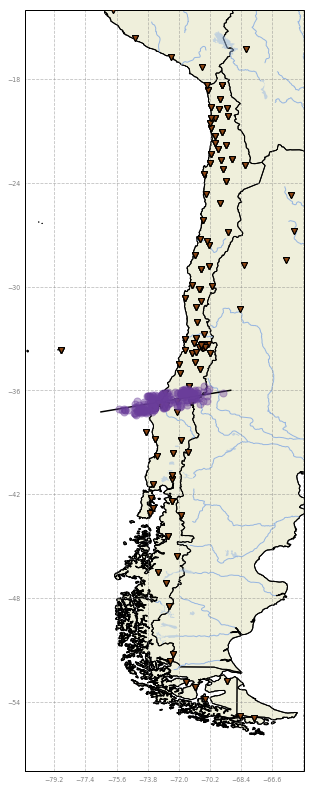

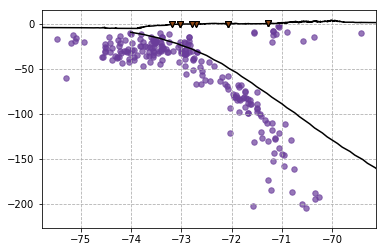

In [6]:
pto1 = (-75, -36)
pto2 = (-72, -35.5)


c=0

m, c = np.polyfit([pto1[0], pto2[0]], [pto1[1], pto2[1]], 1)
c=c-1
x = np.linspace(-76.5,-69)
y = m * x + c


recta = m, c
latitudes = list(df['latitud'])
longitudes = list(df['longitud'])
profundidades = list(-df['profundidad'])

long_project, lat_project, prof_project = proyectar_prof(recta, longitudes, latitudes, profundidades, dist_min=0.5)
        
f = plt.figure(figsize=(5,14))
ax = plt.axes(projection = ccrs.PlateCarree())
plotMap(ax, -80.4, -65.2, -58, -14, Convergencia=False)
ax.scatter(long_project, lat_project, color=coloresmapa[9], label='J', zorder=10, alpha=0.4, s=50)
#ax.axhline(y=-38, color=coloresmapa[9], linestyle='-.')
ax.plot(x,y,'k')
ax.plot(estaciones_lonlatelev[:,0], estaciones_lonlatelev[:,1], 'v', color='saddlebrown', markeredgecolor='k', zorder=9)


# Proyeccion
plt.figure()
plt.scatter(long_project, prof_project, color=coloresmapa[9],alpha=0.7, s=30)   
#plt.errorbar(long_project, prof_project, linestyle="None", color=coloresmapa[9])
#plt.colorbar()

xmin, xmax, ymin, ymax = plt.axis()
largo = (xmax - xmin) * 111.111
angulo = 90 - np.degrees(np.arctan(m))

arch_slab = "/home/tati/Documents/GMT/Grillas/sam_slab2_dep_02.23.18.xyz"
arch_topo = "/home/tati/Documents/GMT/Grillas/topochile30.xyz"
ejecutable = "gmt project %s -C%s/%s -A%s -Fpqrsxyz -W-1.5/1.5 -S -Q -L0/%s -Vn > slab.tmp"%(arch_slab, xmin, pto1[1], angulo, largo)
os.system(ejecutable)
ejecutable = "gmt project %s -C%s/%s -A%s -Fpqrsxyz -W-1.5/1.5 -S -Q -L0/%s -Vn > topo.tmp"%(arch_topo, xmin, pto1[1], angulo, largo)
os.system(ejecutable)
slab = np.loadtxt('slab.tmp', usecols=[2,6])
topo = np.loadtxt('topo.tmp', usecols=[2,6])

plt.plot(slab[:,0], slab[:,1], 'k')
plt.plot(topo[:,0], topo[:,1]/1000, 'k')

longest_project, latest_project, elev_project = proyectar_prof(recta,estaciones_lonlatelev[:,0], estaciones_lonlatelev[:,1], estaciones_lonlatelev[:,2], dist_min=0.5)
plt.plot(longest_project, np.array(elev_project)/1000, 'v', color='saddlebrown', markeredgecolor='k',)

plt.grid(linestyle='--')
plt.xlim((xmin, xmax))